<a href="https://colab.research.google.com/github/MUYang99/Time-Series-Prediction-Based-on-Deep-Learning/blob/main/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from scipy import stats, arange
from matplotlib.pyplot import MultipleLocator
from sklearn import tree

In [2]:
### Import data & dropna
df = pd.read_excel('d2.xlsx')
df = df.dropna()
### Data selection(date)
data = df[df.Date < '20151231']
# data = df
data = data.drop(["Date"], axis=1)
### Average hour data
d1 = data.values
n = d1.shape[0]%4
m = int((d1.shape[0] - n)/4)
avg = np.zeros((m, d1.shape[1]))
for i in range(d1.shape[1]):
  di = d1[:,i].tolist()
  x = len(di)%4
  while x:
    di.pop()
    x -= 1
  arr = np.array(di).reshape(m, 4)
  temp = np.mean(arr, axis = 1)
  avg[:, i] = temp

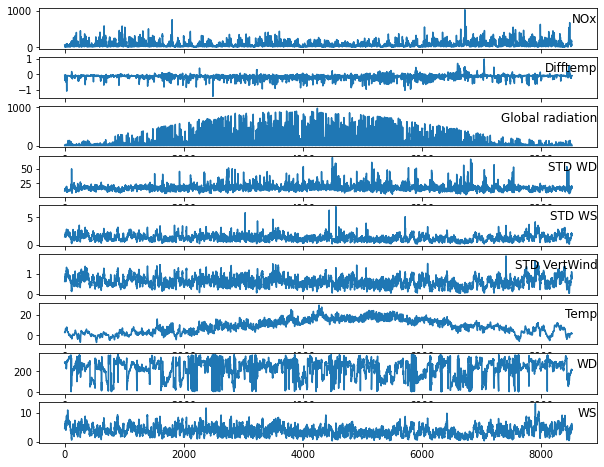

In [12]:
### All data
groups = [0,1,2,3,4,5,6,7,8]
i = 1
# plot each column
plt.figure(figsize = (10, 8))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(avg[:, group])
	plt.title(df.columns[group+1], y=0.5, loc='right')
	i += 1
plt.show()

In [4]:
### Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(avg)

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

n_lag = 5
n_features = 9
reframed = series_to_supervised(data, n_lag, 1)
reframed.drop(reframed.columns[[46,47,48,49,50,51,52,53]], axis=1, inplace=True)
reframed.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t)
5,0.056084,0.565795,5.140057e-07,0.109930,0.194870,0.315667,0.271125,0.787398,0.331487,0.030502,0.494351,7.710085e-07,0.115225,0.221852,0.394481,0.283656,0.793448,0.414621,0.025261,0.424791,0.000000e+00,0.103693,0.217485,0.405409,0.271728,0.787891,0.451252,0.033897,0.551883,2.570028e-07,0.110205,0.231438,0.427400,0.269740,0.790283,0.439048,0.008300,0.556904,0.000000e+00,0.130680,0.224628,0.417156,0.270204,0.786132,0.411298,0.013022
6,0.030502,0.494351,7.710085e-07,0.115225,0.221852,0.394481,0.283656,0.793448,0.414621,0.025261,0.424791,0.000000e+00,0.103693,0.217485,0.405409,0.271728,0.787891,0.451252,0.033897,0.551883,2.570028e-07,0.110205,0.231438,0.427400,0.269740,0.790283,0.439048,0.008300,0.556904,0.000000e+00,0.130680,0.224628,0.417156,0.270204,0.786132,0.411298,0.013022,0.558264,2.570028e-07,0.147430,0.228551,0.417566,0.269740,0.774594,0.355603,0.006672
7,0.025261,0.424791,0.000000e+00,0.103693,0.217485,0.405409,0.271728,0.787891,0.451252,0.033897,0.551883,2.570028e-07,0.110205,0.231438,0.427400,0.269740,0.790283,0.439048,0.008300,0.556904,0.000000e+00,0.130680,0.224628,0.417156,0.270204,0.786132,0.411298,0.013022,0.558264,2.570028e-07,0.147430,0.228551,0.417566,0.269740,0.774594,0.355603,0.006672,0.557531,5.140057e-07,0.133701,0.235917,0.448299,0.266332,0.766433,0.403661,0.005112
8,0.033897,0.551883,2.570028e-07,0.110205,0.231438,0.427400,0.269740,0.790283,0.439048,0.008300,0.556904,0.000000e+00,0.130680,0.224628,0.417156,0.270204,0.786132,0.411298,0.013022,0.558264,2.570028e-07,0.147430,0.228551,0.417566,0.269740,0.774594,0.355603,0.006672,0.557531,5.140057e-07,0.133701,0.235917,0.448299,0.266332,0.766433,0.403661,0.005112,0.563912,4.769982e-04,0.136250,0.216189,0.411009,0.272857,0.778252,0.387124,0.005126
9,0.008300,0.556904,0.000000e+00,0.130680,0.224628,0.417156,0.270204,0.786132,0.411298,0.013022,0.558264,2.570028e-07,0.147430,0.228551,0.417566,0.269740,0.774594,0.355603,0.006672,0.557531,5.140057e-07,0.133701,0.235917,0.448299,0.266332,0.766433,0.403661,0.005112,0.563912,4.769982e-04,0.136250,0.216189,0.411009,0.272857,0.778252,0.387124,0.005126,0.563703,5.440239e-03,0.157197,0.244171,0.438738,0.290659,0.757217,0.377038,0.004333


In [6]:
values = reframed.values
n_val_hours = 3*24
train = values[:-n_val_hours, :]
test = values[-n_val_hours:,:]

train_X, train_y = train[:-n_lag, :-1], train[:-n_lag, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8433, 45) (8433,) (72, 45) (72,)


In [7]:
# design dtree model
clf = tree.DecisionTreeRegressor()
# fit model
clf.fit(train_X,train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [8]:
# make a prediction
predict_y = clf.predict(test_X)
yhat = predict_y.reshape(predict_y.shape[0],1)
test_X = test_X.reshape((test_X.shape[0],n_lag*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -8:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
Prediction = inv_yhat[:,0]

In [9]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -8:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
Truth = inv_y[:,0]

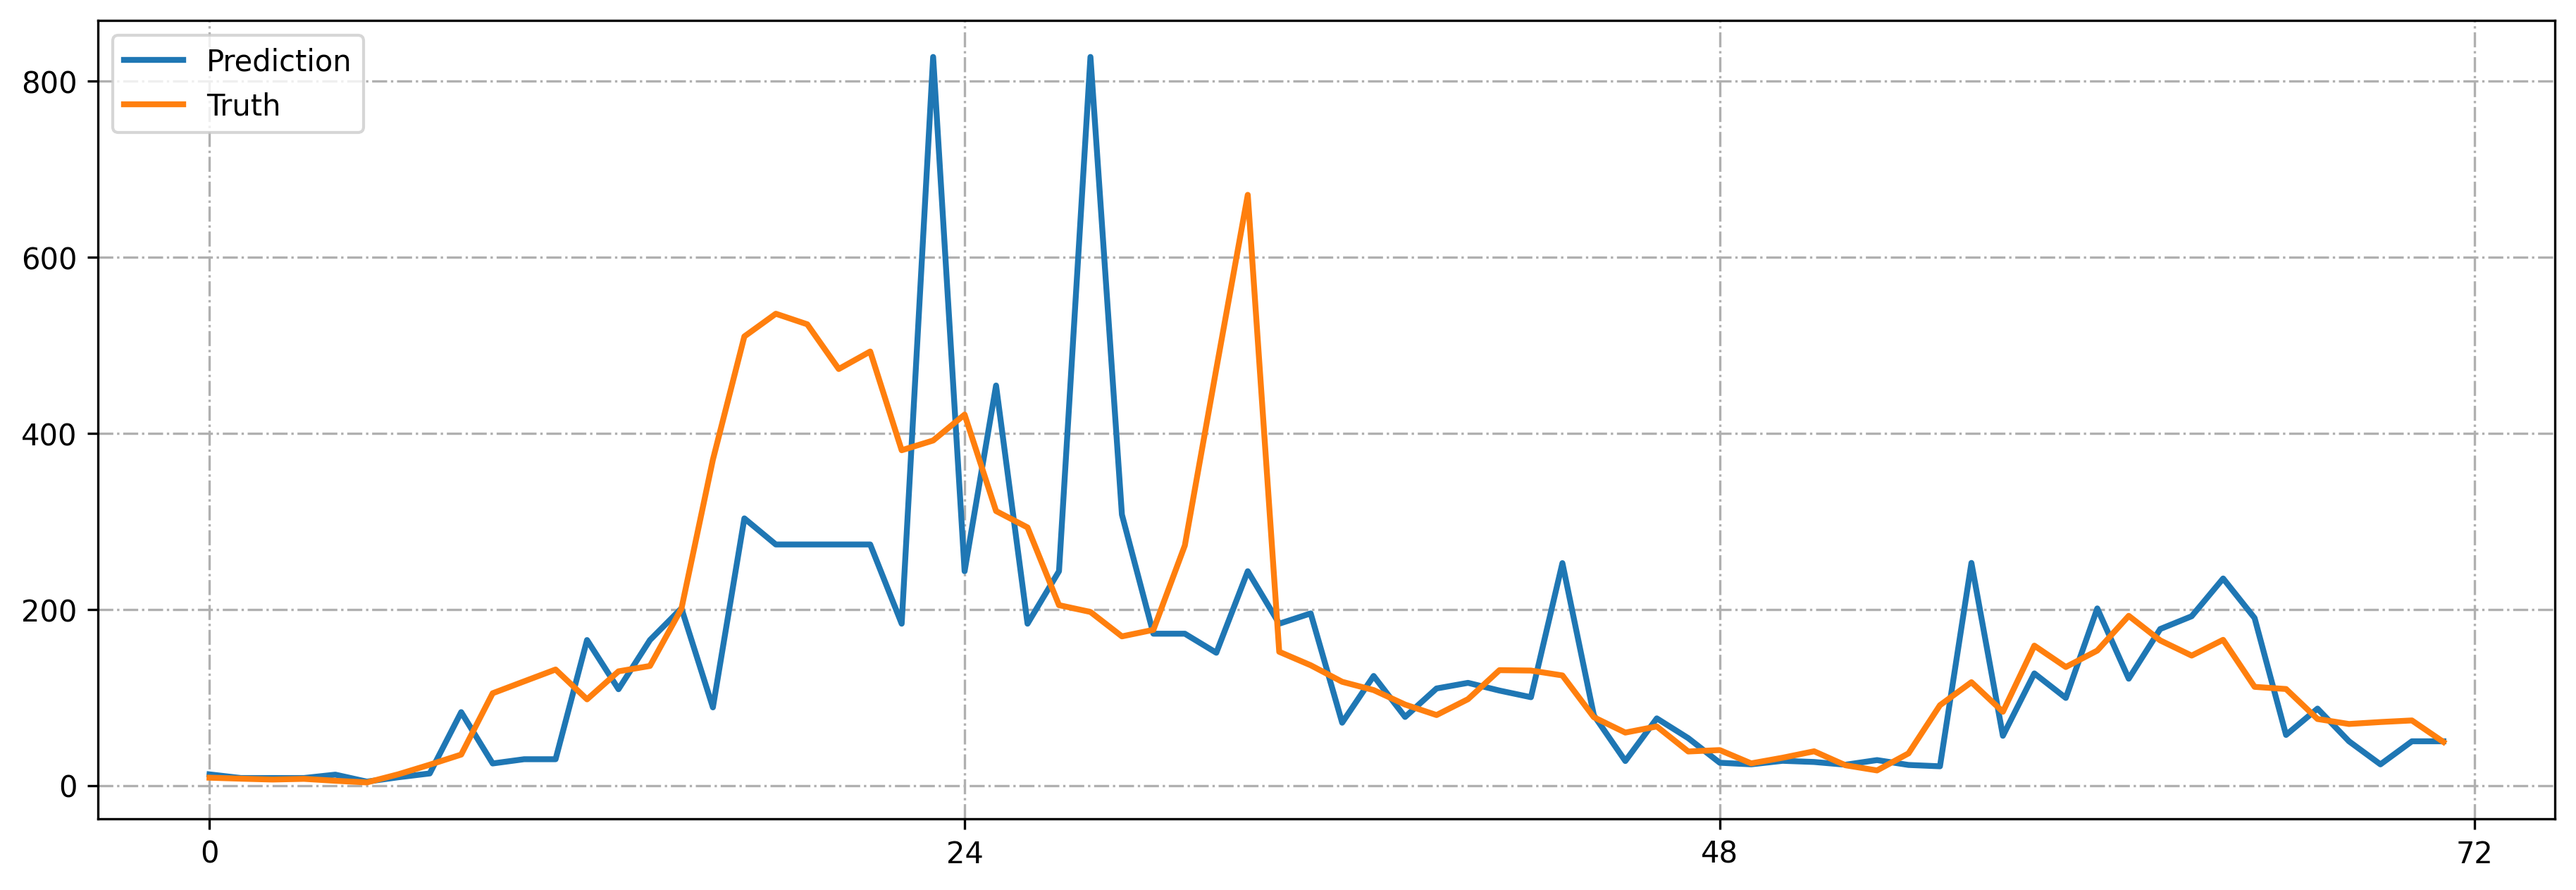

In [10]:
### Visualization
x = [x for x in range(n_val_hours)]
fig, ax = plt.subplots(figsize=(15,5), dpi = 300)
ax.plot(x, Prediction, linewidth=2.0, label = "Prediction")
ax.plot(x, Truth, linewidth=2.0, label = "Truth")

x_major_locator=MultipleLocator(24)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)

ax.legend(loc=2);
plt.grid(linestyle='-.')
plt.show()

In [11]:
### Analysis
MSE = mean_squared_error(Truth, Prediction)
RMSE = np.sqrt(MSE)
print('RMSE: %.3f' %RMSE)
MAE = mean_absolute_error(Truth, Prediction)
print('MAE: %.3f' %MAE)
MAPE = np.mean(np.abs((Truth - Prediction) / Truth)) * 100
print('MAPE: %.3f' %MAPE)
MedAE = median_absolute_error(Truth, Prediction)
print('MedAE: %.3f' %MedAE)
r2_score = r2_score(Truth, Prediction)
print('r2_score: %.3f' %r2_score)
explained_variance_score = explained_variance_score(Truth, Prediction)
print('explained_variance_score: %.3f' %explained_variance_score)

RMSE: 142.450
MAE: 81.908
MAPE: 45.435
MedAE: 32.094
r2_score: 0.134
explained_variance_score: 0.150
